# DataMadness
Group: 20  
Date: 24/03/2021  
Members:
- Stijn Coppens, i6158177
- Tijn Logtens, i6184746
- Luc Sparidans, i6166245

## Table of Contents
* [Imports / Setup](#I/S)
    * [API](#API)
* [Question 1](#q1)
* [Question 2](#q2)
* [Question 3](#q3)
    * [Scraping](#q3.1)
    * [Data cleaning](#q3.2)
    * [Analysis](#q3.3)
* [Question 4](#q4)

## Imports / Setup <a class="anchor" id="I/S"></a>

### API <a class="anchor" id="API"></a>
We used the yFinance API to get the stock market data from our companies of interest. This API can be installed by executing one of the following methods:

Install yfinance using pip:

`$ pip install yfinance --upgrade --no-cache-dir`

Install yfinance using conda:

`$ conda install -c ranaroussi yfinance`

***Link to their github repository:*** <a href="https://github.com/ranaroussi/yfinance" target="_top">yfinance</a>

In [14]:
# imports and setup
import scipy as sc
import numpy as np

import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)

from matplotlib import cm

import yfinance as yf
from bs4 import BeautifulSoup
import urllib.request
import datetime

## Question 1 <a class="anchor" id="q1"></a>
 Which of the marketing criteria were most popular among companies every year and has this changed over time?

## Question 2 <a class="anchor" id="q2"></a>
Can we infer a preference for the criteria which companies like to show most often in their advertisements?

## Question 3 <a class="anchor" id="q3"></a>
Which of the criteria have the most influence on the monthly profit (measured as the price of their stock) of the company?

### 3.1 Scraping <a class="anchor" id="q3.1"></a>

In [15]:
url = "http://www.espn.com/nfl/superbowl/history/winners"

req = urllib.request.Request(url)
with urllib.request.urlopen(req) as response:
    html = response.read()

class_soup = BeautifulSoup(html, 'html.parser')

# we can retreive all tables, our desired table is the first one:
table_html = class_soup("table")[0]

# converting to pandas dataframe
dates = pd.read_html(str(table_html), header=0)[0]

# selecting only the Year and Date column
dates['Year'] = dates['Super Bowl Winners and Results.1']
dates['Date'] = dates['Super Bowl Winners and Results.1']
dates = dates.drop(['Super Bowl Winners and Results','Super Bowl Winners and Results.1','Super Bowl Winners and Results.2','Super Bowl Winners and Results.3'], axis=1)
dates = dates.drop(0)

# maping the Year column to only year 
# make true if you want int instead of string
inte = True
def year(year):
    tmp = year.split()
    if inte:
        return int(tmp[2])
    else:
        return tmp[2]
    
dates['Year'] = dates['Year'].map(year)
dates = dates.loc[dates['Year'] > 1999]
dates = dates.loc[dates['Year'] < 2021]

# Maping the Date column to datetime datatype
def date(date):
    tmp = date.split()
    tmp1 = int(tmp[2])
    tmp2 = tmp[1]
    tmp2 = int(tmp2[:len(tmp[1])-1])
    if 'Jan' in tmp[0]:
        return datetime.datetime(tmp1,1,tmp2)
    else:
        return datetime.datetime(tmp1,2,tmp2)

dates['Date'] = dates['Date'].map(date)

# Reading the superbowl ads csv and selecting every brand
name = pd.read_csv("DataSets/superbowl-ads.csv")
name = name.drop_duplicates(subset=['brand'])

# constructing a series with the right information
d = ['TM','BUD','HYMTF','KO','KIMTF','BUD',' ','PEP','PEP','ETFC']
stock_name = pd.Series(data=d, index=name['brand'])

**Note:** Dropped E-Trade and NFL since they do not have valid stock information listed on Yahoo Finance.

In [16]:
COMPANIES = ['TM','BUD','HYMTF','KO','KIMTF','PEP']
all_data = pd.DataFrame()
for NAME in COMPANIES:
    stock = yf.Ticker(NAME)
    df = stock.history(start="2000-01-01",end="2021-01-01",interval="1mo")
    df = df.dropna()
    df = df.drop(['Dividends','Stock Splits'],axis=1)
    avg_price = (df['Low'] + df['High']) / 2
    all_data[NAME] = avg_price

In [17]:
tmp = []
for year in dates['Year']:
    tmp.append((all_data.loc[''.join((str(year),'-03-01'))]-all_data.loc[''.join((str(year),'-01-01'))]))

delta = pd.DataFrame(tmp)
delta = delta.set_index(dates['Year'])
delta

,TM,BUD,HYMTF,KO,KIMTF,PEP
Year,,,,,,
2000,2.595830,NaN,NaN,-3.819183,NaN,-1.806183
2001,4.923669,NaN,NaN,-2.780090,NaN,-1.329734
2002,2.060956,NaN,NaN,1.136054,NaN,1.012728
2003,-3.517020,NaN,NaN,-0.857207,NaN,-1.519111
2004,2.306189,NaN,NaN,-0.218303,NaN,3.450902
2005,-2.274487,NaN,NaN,0.337806,NaN,0.108706
2006,2.687965,NaN,NaN,0.503495,NaN,0.755313
2007,-0.948208,NaN,NaN,-0.358122,NaN,-0.534009
2008,2.804343,NaN,NaN,-0.567512,NaN,-1.960651


As can be seen from the cells above, we quantify the performance of an ad as the increase of the stockprice as calculated by `month_after - month_before`.

### 3.2 Data Cleaning <a class="anchor" id="q3.2"></a>

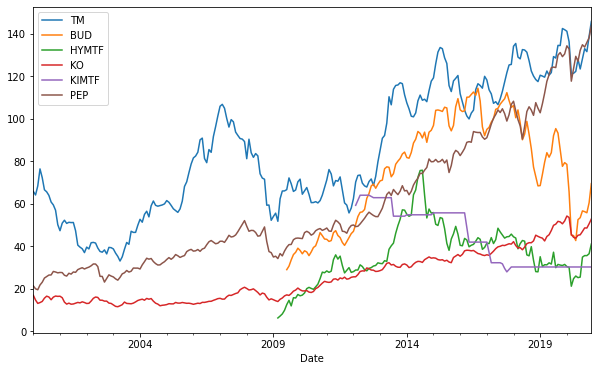

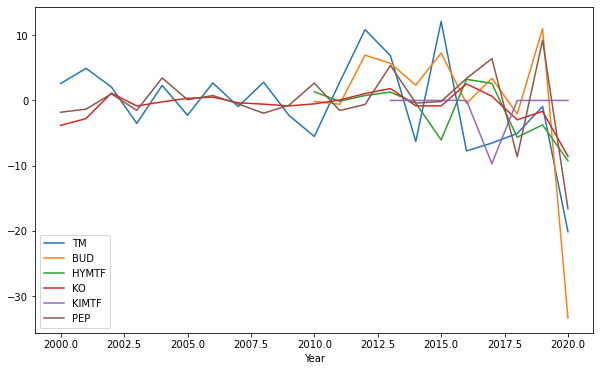

In [18]:
all_data.plot()
delta.plot()

In [19]:
ad = pd.read_csv('../DataMadness/DataSets/superbowl-ads(sorted).csv')
ad = ad.drop(['superbowl_ads_dot_com_url','youtube_url'],axis=1)
ad = ad.set_index('year')
ad = ad[(ad['brand'] != 'E-Trade') & (ad['brand'] != 'NFL')]
ad

,brand,funny,show_product_quickly,patriotic,celebrity,danger,animals,use_sex
year,,,,,,,,
2000,Budweiser,True,True,False,False,False,False,False
2000,Bud Light,True,True,False,False,True,False,False
2000,Budweiser,True,False,False,False,False,True,False
2000,Bud Light,True,False,False,False,True,True,True
2000,Budweiser,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...
2020,Kia,False,False,False,True,False,False,False
2020,Hynudai,True,True,False,True,False,True,False
2020,Budweiser,False,True,True,True,True,False,False


In [20]:
name = ad.drop_duplicates(subset=['brand'])
d = ['BUD','BUD','PEP','PEP','TM','KO','HYMTF','KIMTF']
stock_name = pd.Series(data=d, index=name['brand'])
def stock(name):
    return stock_name.loc[name]
ad['stock_name'] = ad['brand'].map(stock)
ad

,brand,funny,show_product_quickly,patriotic,celebrity,danger,animals,use_sex,stock_name
year,,,,,,,,,
2000,Budweiser,True,True,False,False,False,False,False,BUD
2000,Bud Light,True,True,False,False,True,False,False,BUD
2000,Budweiser,True,False,False,False,False,True,False,BUD
2000,Bud Light,True,False,False,False,True,True,True,BUD
2000,Budweiser,True,True,False,False,False,False,False,BUD
...,...,...,...,...,...,...,...,...,...
2020,Kia,False,False,False,True,False,False,False,KIMTF
2020,Hynudai,True,True,False,True,False,True,False,HYMTF
2020,Budweiser,False,True,True,True,True,False,False,BUD


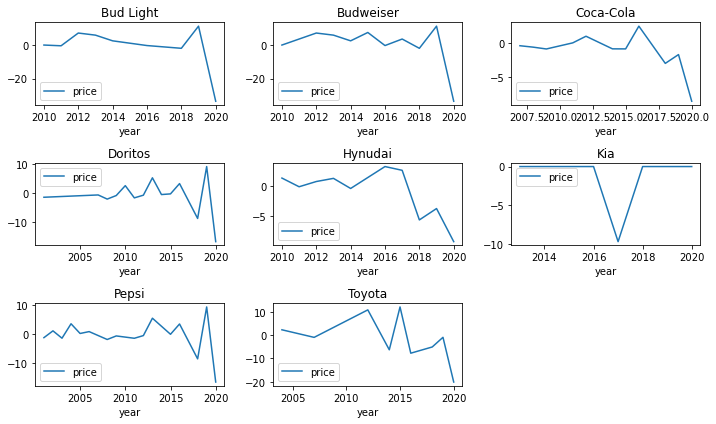

In [21]:
price = []
for index, row in ad.iterrows():
    price.append(delta.loc[index, row['stock_name']])
ad['price'] = price
ad = ad.dropna()
brands = ad.groupby(['brand'])
plt.figure()

# Iterate through continents

for i, (brand_name, price) in enumerate(brands):
    # create subplot axes in a 3x3 grid
    ax = plt.subplot(3, 3, i + 1) # nrows, ncols, axes position
    # plot the continent on these axes
    price.plot(ax=ax)
    # set the title
    ax.set_title(brand_name)

plt.tight_layout()
plt.show()

### 3.3 Analysis <a class="anchor" id="q3.3"></a>

In [22]:
SLR = sm.ols("price ~ celebrity + danger + use_sex", data=ad).fit()
SLR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     8.638
Date:                Wed, 24 Mar 2021   Prob (F-statistic):           2.62e-05
Time:                        15:38:07   Log-Likelihood:                -466.10
No. Observations:                 147   AIC:                             940.2
Df Residuals:                     143   BIC:                             952.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.8121      0.711      2.548      0.012       0.406       3.218
celebrity[T.True]    -4.4061      1.028     -4.285      0.000      -6.439      -2.374
danger[T.True]       -2.3274      1.029     -2.262      0.025      -4.361      -0.293
use_sex[T.True]       2.4629      1.163      2.118      0.036       0.164       4.761
==============================================================================
Omnibus:                       65.134   Durbin-Watson:                   1.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              339.767
Skew:                          -1.497   Prob(JB):                     1.66e-74
Kurtosis:                       9.819   Cond. No.                         2.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation:**  
Our $H_0$ would be that there is no relationship between $x_0,\dots,x_n$.   
In our model: $$ price \sim \beta_0 + \beta_1 celebrity + \beta_2 danger + \beta_3 use\_sex,$$
that would mean that $\beta_0, \dots, \beta_3 = 0$. Since we see non-zero coefficients for each of these and their p-values are less than our chosen accuracy of $\alpha = 5\%$ we cannot reject $H_0$.
This indicates that there is some relationship between the price and the variables we chose for our model.

Because the $R^2$ value is only `0.153` meaning that only 15% (approximately) of the variance in our data can be explained by our model, we know this is not an accurate model.

In [23]:
ad_no_kia = ad[ad['brand'] != 'Kia']
nk_r = sm.ols("price ~ celebrity + danger + use_sex", data=ad_no_kia).fit()
nk_r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     8.295
Date:                Wed, 24 Mar 2021   Prob (F-statistic):           4.24e-05
Time:                        15:38:07   Log-Likelihood:                -437.71
No. Observations:                 137   AIC:                             883.4
Df Residuals:                     133   BIC:                             895.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.8860      0.749      2.517      0.013       0.404       3.368
celebrity[T.True]    -4.7802      1.114     -4.289      0.000      -6.985      -2.576
danger[T.True]       -2.3564      1.097     -2.147      0.034      -4.527      -0.186
use_sex[T.True]       2.6862      1.250      2.149      0.033       0.213       5.159
==============================================================================
Omnibus:                       57.160   Durbin-Watson:                   1.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              262.744
Skew:                          -1.409   Prob(JB):                     8.83e-58
Kurtosis:                       9.171   Cond. No.                         2.87
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

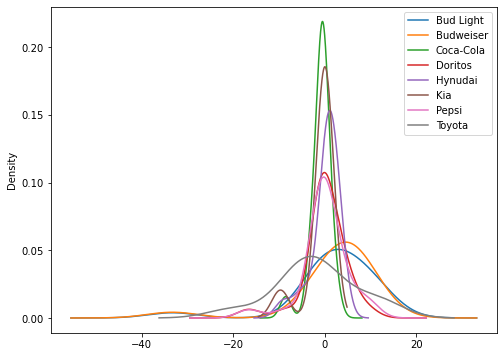

In [24]:
brnds = ad[['brand','price']].groupby(['brand'])

fig, ax = plt.subplots(figsize=(8,6))
for label, df in brnds:
    df.price.plot(kind="kde", ax=ax, label=label)
plt.legend()

The figure shown above indicates that the company that has had the most successful ads during the superbowl is Anheuser-Busch which is the parent company for both Bud light and Budweiser. Those ads seem to get the highest increase in stockprice for the given timeframe.

## Question 4 <a class="anchor" id="q4"></a>
Can we infer a preference for the criteria which companies like to show most often in their advertisements?

In [25]:
grp = ad.groupby('brand')[['funny', 'show_product_quickly', 'patriotic', 'celebrity', 'danger', 'animals', 'use_sex']]
tmp = pd.DataFrame(grp.sum())
size = grp.size()
for index, row in tmp.iterrows():
    tmp.loc[index] = row.divide(size.loc[index])
tmp

,funny,show_product_quickly,patriotic,celebrity,danger,animals,use_sex
brand,,,,,,,
Bud Light,0.842105,0.894737,0.105263,0.368421,0.368421,0.421053,0.263158
Budweiser,0.117647,0.705882,0.647059,0.117647,0.235294,0.647059,0.176471
Coca-Cola,0.380952,0.714286,0.238095,0.285714,0.285714,0.571429,0.047619
Doritos,0.960000,0.880000,0.040000,0.160000,0.440000,0.400000,0.240000
Hynudai,0.578947,0.473684,0.157895,0.315789,0.315789,0.368421,0.157895
Kia,0.500000,0.200000,0.200000,0.600000,0.400000,0.400000,0.300000
Pepsi,0.720000,0.600000,0.120000,0.640000,0.240000,0.120000,0.440000
Toyota,0.545455,0.818182,0.181818,0.181818,0.363636,0.272727,0.090909
